In [368]:
from models import *
from datetime import datetime
from random import random
from functions import GetCurrentDate
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os

# Initiate parameters
start_date = "2019-12-30"  #"2018-12-31"  
end_date = GetCurrentDate() #'2023-04-30'
ticker = 'tsla'
period = "1wk" 
shuffle = True
condition = False

# Sentiment types... APISentiment	VaderSentiment	CombinedVaderSentiment RobertaLargeSentiment #TwitterSentiment
sentiment = True
sentiment_type = 'TwitterSentiment'
aggr_function = 'mean'

#Setup windows
formation_window = 4
target_window = 1

#Split Ratios
split_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15

if condition:
    print("--> Condition is ENABLED")
# EMA indicators
indicator1 = 1#5
indicator2 = 2#8
indicator3 = 3#21

#TSLA: 1 2 3
#MRK: 5 8 21

# training batches
batch_size_train = 6
batch_size_valid = 2

#Clear Folders
delete = True
export_excels = False

#__________________________________________________
# Do not change
api_key = '631505e804ec58.42743136'
window_size = formation_window + 1

if sentiment == False:
    news_df = None
if sentiment_type == 'TwitterSentiment':
    twitter = True
else:
    twitter = False

excel_reports = ".\Excel reports"
temp = f".\TempFiles\{ticker}"

#Delete folders
if delete == True:
    try:
        shutil.rmtree(excel_reports)
        shutil.rmtree(temp)
    except:
        pass
    # Create folder, if exist pass exception
    try:
        os.mkdir("Excel reports")
        os.mkdir(f"TempFiles\{ticker}")
    except:
        pass

# Print stuffs
print("\nTensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("\nwindow size: ", window_size)
print("formation_window: ", formation_window)
print("target_window: ", target_window)
print("chart period: ", period)


End Date:  2023-05-28

Tensorflow version:  2.9.1
Numpy version:  1.23.1

window size:  5
formation_window:  4
target_window:  1
chart period:  1wk


In [369]:
if sentiment == True:

    from sentiment import GetNews

    GetNewsAPI = GetNews()

    GetNewsAPI.fit(ticker=ticker, start_date=start_date, end_date=end_date,
                   n_news=1000, token=api_key, offset=0, export_excel=True, twitter=twitter,temp_folder=temp)
    news_df = GetNewsAPI.transform()
news_df.shape


--------> GetNews completed



(429, 2)

In [370]:
from transformers_preprocess import PullData

GetData = PullData()

print("ticker: ",ticker)
print("condition: ",condition)

GetData.fit(ticker=ticker,
            start_date=start_date,
            end_date=end_date,
            interval=period,  
            progress=False,
            condition=condition,
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=indicator1,
            timeperiod2=indicator2,
            timeperiod3=indicator3,
            export_excel=export_excels,
            excel_path=excel_reports,
            listed_conditions=None,
            sentiment=sentiment,
            sentiment_type=sentiment_type, 
            news_df=news_df,
            chart_period=period,
            sentiment_aggr=aggr_function,
            )

data_prep = GetData.transform()

# Validation
if window_size != (formation_window + 1):
    raise Exception(
        f"Error - window_size ({window_size}) must be equal to sum of formation_window ({formation_window}) and value 1.")

df = data_prep[data_prep['Date']!= "Month"].copy()

# Function to check if date is Monday
def is_monday(date):
    return date.weekday() == 0
# Loop through first 5 rows and check if the date is Monday
for index, row in df.head(10).iterrows():
    date_obj = row['Date'].date()

    if not is_monday(date_obj):
        raise Exception(f"Error: {date_obj} is not Monday.")
    
# IMPORTANT!!!!!!!!!!!!!!!!!!!!!!!!
        
# When getting data via yahoo finance API, with current date, there is distorted last formation, 
# when pulling weekly data, as target, it takes Friday's candle and distorts test set
# therefore we must remove last window.
data_prep = data_prep[:-window_size]
data_prep.tail()

ticker:  tsla
condition:  False
initial shape:  (179, 6)


,Date,Open,High,Low,Close,EMA1,EMA2,EMA3,TwitterSentiment,trades
172,2023-04-17 00:00:00,186.320007,189.690002,160.559998,165.080002,165.080002,172.305613,176.549060,0.0,173
173,2023-04-24 00:00:00,164.649994,165.649994,152.369995,164.309998,164.309998,166.975203,170.429529,0.0,173
174,2023-05-01 00:00:00,163.169998,170.789993,158.830002,170.059998,170.059998,169.031733,170.244763,0.0,173
175,2023-05-08 00:00:00,173.720001,177.380005,166.559998,167.979996,167.979996,168.330575,169.112379,0.0,173
0,Month,167.660004,181.949997,164.350006,180.139999,164.309998,166.975203,170.429529,0.0,173


In [371]:
#NEW CODE______________________
#If shuffle true, get test set that will not be shuffled for evaluation, we will shuffle only train and evaluation set
print("shuffle: ",shuffle)

if shuffle == True:
    from transformers_preprocess import NormalizeData

    NormalizeData = NormalizeData()

    NormalizeData.fit(window_size=window_size, shuffle=False, debug=False,
                    export_excel=export_excels, excel_path=excel_reports, sentiment=sentiment)

    df_ = data_prep.copy()
    ttl_windows = len(df_)/window_size
    testsubset = round(ttl_windows*test_ratio, 0)

    xtest_split = testsubset * window_size
    test_split = int(xtest_split)

    print("DF Shape: ", df_.shape)
    print("test_split split: ", test_split)
    print("Shuffle is: ",shuffle)
        
    x_test_new = df_[-test_split:]

    data_prep = data_prep[:-test_split]
    print("revised data_prep shape",data_prep.shape)
    test_trade_start = int(x_test_new.trades.head(1))

    unshuffled_test, Dates_unshuffled_test = NormalizeData.transform(x_test_new)
#data_normalized_test.tail(10)


shuffle:  True
DF Shape:  (865, 10)
test_split split:  130
Shuffle is:  True
revised data_prep shape (735, 10)
Dataframe shape:  (130, 10)
Number of formations:  26
--------> NormalizeData completed



In [372]:
####################################################################

from transformers_preprocess import NormalizeData

if shuffle == False:
    
    NormalizeData = NormalizeData()

    NormalizeData.fit(window_size=window_size, shuffle=shuffle, debug=False,
                        export_excel=export_excels, excel_path=excel_reports, sentiment=sentiment)

    data_normalized, Dates = NormalizeData.transform(data_prep)
else:
    NormalizeData = NormalizeData()

    NormalizeData.fit(window_size=window_size, shuffle=shuffle, debug=False,
                        export_excel=export_excels, excel_path=excel_reports, sentiment=sentiment)

    data_normalized, Dates = NormalizeData.transform(data_prep) 
#data_normalized.head(8)
# Get only forecasts for model testing
# x_valid_x = data_normalized[['maxv','minv']].copy() #extreme values for reverting normalization
# x_valid = data_normalized.iloc[:,:-2].copy() #dataset for forecast
data_prep


Dataframe shape:  (735, 10)
Number of formations:  147
--------> NormalizeData completed



,Date,Open,High,Low,Close,EMA1,EMA2,EMA3,TwitterSentiment,trades
0,2019-12-30 00:00:00,28.586000,30.266666,26.805332,29.534000,29.534000,29.534000,29.534000,0.000000,1
1,2020-01-06 00:00:00,29.364668,33.253334,29.333332,31.876667,31.876667,31.095778,30.705334,0.000000,1
2,2020-01-13 00:00:00,32.900002,36.493999,32.799999,34.033333,34.033333,33.054148,32.369333,0.000000,1
3,2020-01-20 00:00:00,35.349998,39.633331,35.227333,37.654667,37.654667,36.121161,35.012000,0.000000,1
0,Month,36.132668,43.533333,35.952000,43.371334,31.876667,31.095778,30.705334,0.000000,1
...,...,...,...,...,...,...,...,...,...,...
146,2022-10-17 00:00:00,210.039993,229.820007,202.000000,214.440002,214.440002,215.085504,220.806865,0.140643,147
147,2022-10-24 00:00:00,205.820007,233.809998,198.589996,228.520004,228.520004,224.041837,224.663434,0.129157,147
148,2022-10-31 00:00:00,226.190002,237.399994,203.080002,207.470001,207.470001,212.993947,216.066718,0.130843,147
149,2022-11-07 00:00:00,208.649994,208.899994,177.119995,195.970001,195.970001,201.644650,206.018360,0.083814,147


In [373]:
####################################################################

from training import SplitData

SplitData = SplitData()

SplitData.fit(split_ratio=split_ratio, window_size=window_size,
              dates=Dates, debug=False, export_excel=export_excels, 
              excel_path=excel_reports, sentiment=sentiment,validation_set=validation_ratio, 
              test_set=test_ratio,shuffle=shuffle)

x_train, x_valid, x_test, x_train_x, x_valid_x, x_test_x, _ = SplitData.transform(data_normalized)


#NEW CODE______________________
print("Shuffle is ",shuffle)
if shuffle==True:
    unshuffled_test_extremes = unshuffled_test.iloc[:,-2:]
    unshuffled_test_df = unshuffled_test.iloc[:,:-2]
    print("test windows: ",unshuffled_test_df.shape[0]/window_size)
else:
    #if shuffle false, get 1st trade on test dataset for docker script
    test_trades = len(x_test)/window_size
    ttl_windows = len(data_prep)/window_size
    test_trade_start = int(ttl_windows-test_trades)
    print("Test trade starting at: ", test_trade_start)

Data_prep Shape:  (735, 10)
train_split split:  515
validation split:  110

Split train ratio: 70 %
Split validation ratio: 15 %

Total Windows (no test set):  147.0
x_train windows:  125.0
x_valid windows:  22.0
--------> SplitData completed

Shuffle is  True
test windows:  26.0


In [374]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=window_size, batch_size=batch_size_train, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

# c = 0
# for batch in x_train_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break


--------> GetTensoredDataset completed



In [375]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=window_size, batch_size=batch_size_valid, train=False, debug=False)

x_valid_tensors, labels_valid = GetTensoredValidDataset.transform(x_valid)

#NEW CODE______________________
#when shuffle false, x_test dataframe is unshuffled from default
print("shuffle is: ", shuffle)

if shuffle==False:
    x_test_tensors, labels = GetTensoredValidDataset.transform(x_test)
else:
    x_test_tensors, labels = GetTensoredValidDataset.transform(unshuffled_test_df)
    x_test = unshuffled_test_df.copy()
    x_test_x = unshuffled_test_extremes.copy()
    Dates = Dates_unshuffled_test.copy()
    
# for batch in x_valid_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break


--------> GetTensoredDataset completed

shuffle is:  True
--------> GetTensoredDataset completed



<b>Model Training</b>

In [376]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

datetime_ = datetime.today().date()
number = int(random()*10000)
model_name_ = f'{ticker}_model_{datetime_}_{number}.h5'
model_name = f'{temp}/{model_name_}'

metric = 'val_loss'
early_stopping = EarlyStopping(
    monitor=metric, patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor=metric, factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=0)

model_checkpoint = ModelCheckpoint(monitor=metric,
                                   filepath=model_name,
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 1000.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Bellow code is used to find the best model architecture, recommended to use cloud computing

In [377]:
# from testing import get_models,optimize
# from datetime import datetime
# start_time = datetime.now().strftime("%H:%M:%S")
# start = datetime.now()
# print("Training started at ",start_time)
# tf.random.set_seed(7788)
# np.random.seed(7788)

# # #Permutation testing
# # num_layers = 2
# # min, max = 2, 4
# # node_step_size = 2
# # node_options = list(range(min, max + 1, node_step_size))
# # two_layer_possibilities = [node_options, node_options]
# # layer_node_permutations  = list(itertools.product(*two_layer_possibilities))

# f_df = pd.DataFrame()

# for layer in range(5,6):
#     progress_time = datetime.now().strftime("%H:%M:%S")
#     print("\n------ > Layer: ",layer)
#     print("Layer loop started: ",progress_time)

#     all_models, names = get_models(num_layers=layer, min=2, max=4, node_step_size=2, features=x_train.shape[1])

#     progress_time = datetime.now().strftime("%H:%M:%S")
#     print("Models: ",len(all_models))
#     print("Models constructed: ",progress_time)
    
#     optimizing_df = optimize(models=all_models,X_train=x_train_tensors,X_valid=x_valid_tensors,X_test=x_valid,labels=labels_valid,epochs=1000,verbose=0,window_size=window_size,callbacks=callbacks,layer=layer,ticker=ticker,excel_path=tested_models)
# # optimizing_df
#     f_df = f_df.append(optimizing_df)
#     f_df.to_excel('test.xlsx')
# end_time = datetime.now().strftime("%H:%M:%S")
# end = datetime.now()
# print("\nTraining ended at ",end_time) 
# print(f"Training ended in {round((end-start).total_seconds(),2)} seconds")

Get Model

In [378]:
from datetime import datetime
start_time = datetime.now().strftime("%H:%M:%S")
start = datetime.now()
print("Training started at ",start_time)

tf.random.set_seed(7788)
np.random.seed(7788)
features = x_train.shape[1]

print(f"Model training - {str.upper(ticker)} \n")

def general_model(features: int):
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv1D(filters=1, kernel_size=10,
                               strides=1, padding="same",
                               activation=tf.nn.selu,
                               input_shape=[None, features]),

        tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(3, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
        tf.keras.layers.Dense(4, activation=tf.nn.selu),
        tf.keras.layers.Dense(3, activation=tf.nn.selu),
        tf.keras.layers.Dense(2, activation=tf.nn.selu),
        tf.keras.layers.Dense(1, activation=tf.nn.relu),
    ])
    return model

# def general_model(features: int):
#     model = tf.keras.models.Sequential([

#         tf.keras.layers.Conv1D(filters=1, kernel_size=10,
#                                strides=1, padding="same",
#                                activation=tf.nn.selu,
#                                input_shape=[None, features]),

#         tf.keras.layers.Bidirectional(
#         tf.keras.layers.LSTM(3, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
#         tf.keras.layers.Dense(2, activation=tf.nn.selu),
#         tf.keras.layers.Dense(2, activation=tf.nn.selu),
#         tf.keras.layers.Dense(2, activation=tf.nn.selu),
#         tf.keras.layers.Dense(1, activation=tf.nn.relu),
#     ])
#     return model

model = general_model(features)

#0.0007
learning_rate = 0.0007

optimizer2 = tf.keras.optimizers.Adam(
            learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False) #0.00007
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.0006, initial_accumulator_value=5, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer2
              )

model.fit(x_train_tensors, epochs=1000, callbacks=[callbacks], validation_data=x_valid_tensors,verbose=1)


end_time = datetime.now().strftime("%H:%M:%S")
end = datetime.now()
print("\nTraining ended at ",end_time) 
print(f"Training ended in {round((end-start).total_seconds(),2)} seconds")



Training started at  17:27:45
Model training - TSLA 

Epoch 1/1000
21/21 [==============================] - 15s 237ms/step - loss: 0.3240 - val_loss: 0.1649 - lr: 7.0000e-04
Epoch 2/1000
21/21 [==============================] - 0s 24ms/step - loss: 0.0952 - val_loss: 0.0595 - lr: 7.0000e-04
Epoch 3/1000
21/21 [==============================] - 0s 21ms/step - loss: 0.0698 - val_loss: 0.0469 - lr: 7.0000e-04
Epoch 4/1000
21/21 [==============================] - 1s 26ms/step - loss: 0.0667 - val_loss: 0.0460 - lr: 7.0000e-04
Epoch 5/1000
21/21 [==============================] - 1s 34ms/step - loss: 0.0630 - val_loss: 0.0453 - lr: 7.0000e-04
Epoch 6/1000
21/21 [==============================] - 0s 22ms/step - loss: 0.0594 - val_loss: 0.0433 - lr: 7.0000e-04
Epoch 7/1000
21/21 [==============================] - 1s 25ms/step - loss: 0.0551 - val_loss: 0.0409 - lr: 7.0000e-04
Epoch 8/1000
21/21 [==============================] - 1s 34ms/step - loss: 0.0501 - val_loss: 0.0384 - lr: 7.0000e-04


In [391]:
from functions import model_forecast
import time

forecast = model_forecast(model, x_test, window_size=window_size, debug=False)

from transformers_preprocess import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_test=x_test, x_test_x=x_test_x, window_size=window_size, debug=False,
                         sentiment=sentiment,sentiment_type=sentiment_type)

df = ReverseNormalization.transform()

time.sleep(3) 

from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_test=x_test,
                      sentiment=sentiment,
                      sentiment_type=sentiment_type)

reversed_df = GetFinalDataframe.transform(df)

time.sleep(1) 

from final_evaluation import GetModelPerformance
#print(f"Window size: {window_size} \n")
print(f"ticker: {str.upper(ticker)}\n")
print(f'Total timeframe: {start_date} - {end_date}\n')
print(f"Shuffle: {shuffle} \n")
GetModelPerformance = GetModelPerformance()

acceptance = 0
penalization = 0.4

#TSLA penalization 0.4

GetModelPerformance.fit(acceptance=acceptance,
                        penalization=penalization,
                        entry_candle='Current Open',#Current Open
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports,
                        sentiment=sentiment)

trades_df = GetModelPerformance.transform(reversed_df)
#trades_df = trades_df.sort_values('Datetime',ascending=True)

trades_df.tail(7)




26/26 [==============================] - 0s 9ms/step
--------> ReverseNormalization completed

--------> GetFinalDataframe

ticker: TSLA

Total timeframe: 2019-12-30 - 2023-05-28

Shuffle: True 

Formations:  26
period: 2022-10-24 - 2023-05-08
Entry Candle:  Current Open

Total Trades:  16
Profit Trades:  14
Loss Trades:  2

Win Ratio: 88.0 %
Loss Ratio: 12 %

Trade nr with exact TP:  6
Ratio of exact TP: 37.5 %

Average profit per trade:  691

Gross profit:  11053
Gross loss:  -475

Net profit:  10578


,Open,High,Low,Close,EMA1,EMA2,EMA3,labels,prediction,TwitterSentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
118,164.649994,165.649994,152.369995,164.309998,164.309998,166.975203,170.429529,nn,nn,0.0,2023-04-24,6.889999,15
119,163.169998,170.789993,158.830002,170.059998,185.000000,186.756834,188.018119,170.789993,179.0531,0.0,2023-04-25,6.889999,15
125,186.320007,189.690002,160.559998,165.080002,165.080002,172.305613,176.549060,nn,nn,0.0,2023-04-17,14.129501,16
126,164.649994,165.649994,152.369995,164.309998,164.309998,166.975203,170.429529,nn,nn,0.0,2023-04-24,14.129501,16
127,163.169998,170.789993,158.830002,170.059998,170.059998,169.031733,170.244763,nn,nn,0.0,2023-05-01,14.129501,16
128,173.720001,177.380005,166.559998,167.979996,167.979996,168.330575,169.112379,nn,nn,0.0,2023-05-08,14.129501,16
129,167.660004,181.949997,164.350006,180.139999,164.309998,166.975203,170.429529,181.949997,181.789505,0.0,2023-05-09,14.129501,16


In [384]:
#trades_df.tail(10)

In [385]:
trade = 1
budget = 10000
entry_candle = 'Current Open'
df = trades_df.head(3)


Trade:  1
Window size:  5
Period: 2022-10-24 - 2022-11-14

Budget:  10000

Entry price:  175.85
Label (target):  185.2
Model prediction:  202.59
Market Change: 7.01 $
Profit: 398.64 $


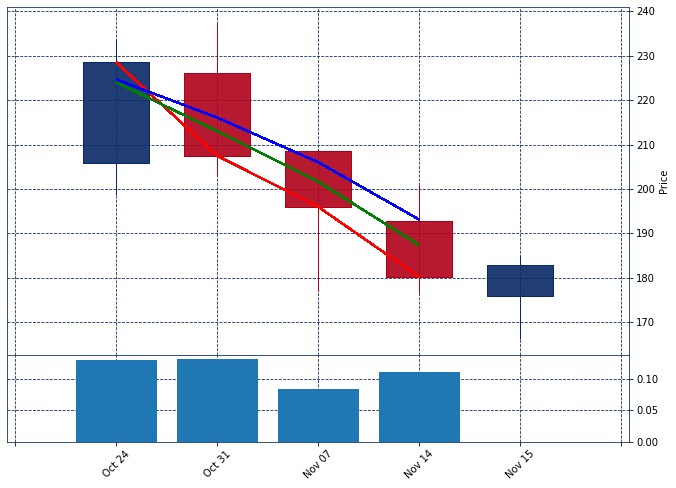

,Open,High,Low,Close,EMA1,EMA2,EMA3,labels,prediction,TwitterSentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
0,205.820007,233.809998,198.589996,228.520004,228.520004,224.041837,224.663434,nn,nn,0.129157,2022-10-24,7.009995,1
1,226.190002,237.399994,203.080002,207.470001,207.470001,212.993947,216.066718,nn,nn,0.130843,2022-10-31,7.009995,1
2,208.649994,208.899994,177.119995,195.970001,195.970001,201.644650,206.018360,nn,nn,0.083814,2022-11-07,7.009995,1
3,192.770004,200.820007,176.550003,180.190002,180.190002,187.341552,193.104181,nn,nn,0.109700,2022-11-14,7.009995,1
4,175.850006,185.199997,166.190002,182.860001,207.470001,212.993947,216.066718,185.199997,202.592785,0.000000,2022-11-15,7.009995,1


In [386]:
#trade = 4
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,
budget=budget,sentiment=sentiment,indicator1=indicator1,indicator2=indicator2,indicator3=indicator3)
trade += 1
df


In [387]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle=entry_candle,#"Current Open"
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
#trades_df_final = trades_df_final.sort_values('Datetime', ascending=True)
trades_df_final.tail(10)

--------> GetPerformanceReport completed



,Open,High,Low,Close,EMA1,EMA2,EMA3,labels,prediction,TwitterSentiment,Datetime,profit,trade,Entry,Performance
100,179.940002,191.580002,176.110001,185.000000,185.000000,186.756834,188.018119,nn,nn,0.0,2023-04-10,0.905030,21,nn,nn
101,186.320007,189.690002,160.559998,165.080002,165.080002,172.305613,176.549060,nn,nn,0.0,2023-04-17,0.905030,21,nn,nn
102,164.649994,165.649994,152.369995,164.309998,164.309998,166.975203,170.429529,nn,nn,0.0,2023-04-24,0.905030,21,nn,nn
103,163.169998,170.789993,158.830002,170.059998,170.059998,169.031733,170.244763,nn,nn,0.0,2023-05-01,0.905030,21,nn,nn
104,173.720001,177.380005,166.559998,167.979996,165.080002,172.305613,176.549060,177.380005,174.625031,0.0,2023-05-02,0.905030,21,173.720001,52.0
105,186.320007,189.690002,160.559998,165.080002,165.080002,172.305613,176.549060,nn,nn,0.0,2023-04-17,14.129501,22,nn,nn
106,164.649994,165.649994,152.369995,164.309998,164.309998,166.975203,170.429529,nn,nn,0.0,2023-04-24,14.129501,22,nn,nn
107,163.169998,170.789993,158.830002,170.059998,170.059998,169.031733,170.244763,nn,nn,0.0,2023-05-01,14.129501,22,nn,nn
108,173.720001,177.380005,166.559998,167.979996,167.979996,168.330575,169.112379,nn,nn,0.0,2023-05-08,14.129501,22,nn,nn
109,167.660004,181.949997,164.350006,180.139999,164.309998,166.975203,170.429529,181.949997,181.789505,0.0,2023-05-09,14.129501,22,167.660004,848.0


<b>Plot Chart With Labels and Predictions</b>

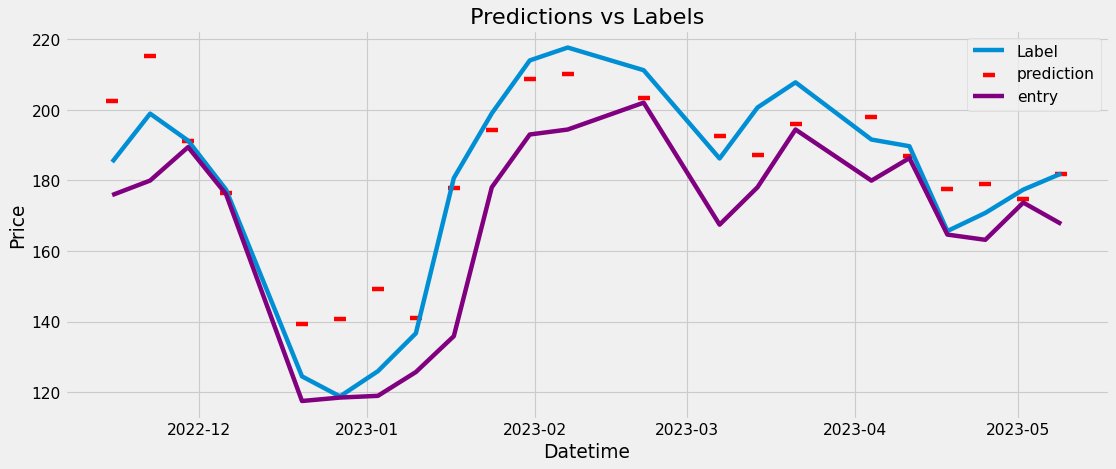

In [388]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
figure(figsize=(15, 6), dpi=80)

df_plot = trades_df_final[['Datetime','labels','prediction','Entry']]
df_plot = df_plot[df_plot.labels != 'nn']

x1 = df_plot['labels']
x2 = df_plot['prediction']
entry = df_plot['Entry']
y = df_plot['Datetime']

# plot lines
plt.plot(y, x1, label = "Label") #,s=200,marker='*'
plt.scatter(y, x2, label = "prediction",color='red', s=100,marker='_')
plt.plot(y, entry, label = "entry",color='purple')#,color='blue', s=100,marker=0
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title('Predictions vs Labels')
plt.legend()
plt.show()

<b>Export dataframe with all variables</b>

In [389]:

def ExportFile():
    today = datetime.today().date()

    variables_dict = \
    {
    'model_name':[model_name_],
    'Date':[today],
    'ticker':[ticker],
    'period':[period],
    'api_key':[api_key],
    'sentiment':[sentiment],
    'sentiment_type':[sentiment_type],
    'aggr_function':[aggr_function],
    'formation_window':[formation_window],
    'target_window':[target_window],
    'split_ratio':[split_ratio],
    'test_ratio':[test_ratio],
    'validation_ratio':[validation_ratio],
    'condition':[condition],
    'indicator1':[indicator1],
    'indicator2':[indicator2],
    'indicator3':[indicator3],
    'window_size':[window_size],
    'formation_window':[formation_window],
    'twitter':[twitter],
    'start_date':[start_date],
    'end_date':[end_date],
    'batch_size_train':[batch_size_train],
    'batch_size_valid':[batch_size_valid],
    'shuffle':[shuffle],
    'entry_candle':[entry_candle],
    'excel_reports':[excel_reports],
    'acceptance':[acceptance],
    'penalization':[penalization],
    'learning_rate':[learning_rate],
    'test_set_start':[test_trade_start]
    }

    x_test.to_csv(f'{temp}/{ticker}_test_data.csv')
    x_test_x.to_csv(f'{temp}/{ticker}_x_test_x.csv')
    test_start = len(Dates)-x_test.shape[0]
    Dates_test = Dates[test_start:]
    Dates_test.to_csv(f'{temp}/{ticker}_dates_test.csv')
    Dates.to_csv(f'{temp}/{ticker}_Dates.csv')
    df = pd.DataFrame(variables_dict).transpose()
    df.to_csv(f'{temp}/variables_df.csv')
    return df

df = ExportFile()
#df


In [390]:
from final_evaluation import MakeSinglePrediction


MakeSinglePrediction = MakeSinglePrediction()

print('penalization: ',penalization)
print('acceptance: ',acceptance)
fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=formation_window,
                        ticker=ticker,
                        start_date=start_date,
                        end_date="2023-05-28",
                        interval=period, #1wk
                        progress=False,
                        condition=condition,
                        timeperiod1=indicator1,
                        timeperiod2=indicator2,
                        timeperiod3=indicator3,
                        debug=False,
                        budget=10000,
                        penalization=penalization,
                        acceptance=acceptance,
                        entry_candle='Current Close',
                        news_df=news_df,
                        sentiment=sentiment,
                        sentiment_type=sentiment_type,
                        sentiment_aggr=aggr_function)

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]
final_trade_formation = trade_formation.head(formation_window)
final_trade_formation
###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method

#final_trade_formation.tail()


penalization:  0.4
acceptance:  0


,Date,Open,High,Low,Close,EMA1,EMA2,EMA3,TwitterSentiment
0,2023-04-24,164.649994,165.649994,152.369995,164.309998,164.309998,166.975203,170.429529,0.077286
1,2023-05-01,163.169998,170.789993,158.830002,170.059998,170.059998,169.031733,170.244763,0.104043
2,2023-05-08,173.720001,177.380005,166.559998,167.979996,167.979996,168.330575,169.112379,0.116214
3,2023-05-15,167.660004,181.949997,164.350006,180.139999,180.139999,176.203524,174.626189,0.047443



Ticker:  mrk
1/1 [==============================] - 5s 5s/step

Entry candle (Current Close)

Budget:  10000

Entry price:  111.07
Prediction:  114.57
Expected Market move:  3.5
Expected Profit:  315.12


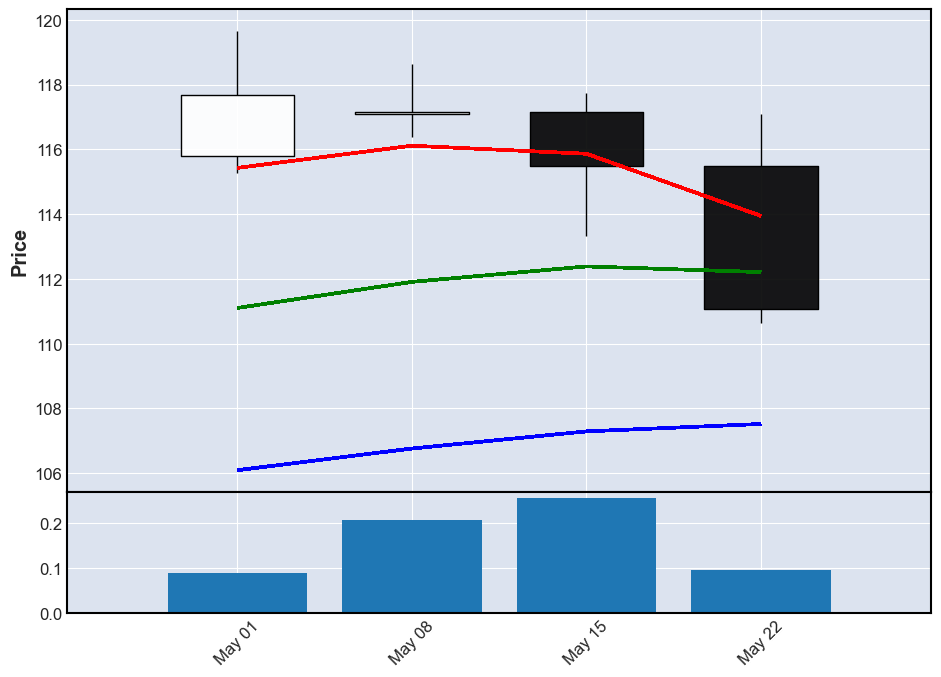

In [109]:
#Make prediction
MakeSinglePrediction.transform(final_trade_formation)

#PLot current chart and sentiment
from plotting import PlotCurrentFormation

PlotCurrentFormation(final_trade_formation,sentiment=sentiment,indicator1=indicator1,indicator2=indicator2,indicator3=indicator3)
